Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Data successfully split:
Training patients: 48, Validation patients: 12
Training slices: 450
Validation slices: 132

Using device: cpu

--- Starting Baseline Model Training (Expanded Dataset) ---


Validation: 100%|██████████| 9/9 [01:46<00:00, 11.86s/it]


Epoch 1/5 -> Train Loss: 0.7272, Val Loss: 0.9376, Val Dice: 0.0726


Validation: 100%|██████████| 9/9 [01:41<00:00, 11.26s/it]


Epoch 2/5 -> Train Loss: 0.6068, Val Loss: 0.6143, Val Dice: 0.6831


Validation: 100%|██████████| 9/9 [01:45<00:00, 11.70s/it]


Epoch 3/5 -> Train Loss: 0.5690, Val Loss: 0.5593, Val Dice: 0.7040


Validation: 100%|██████████| 9/9 [01:41<00:00, 11.29s/it]


Epoch 4/5 -> Train Loss: 0.5469, Val Loss: 0.5835, Val Dice: 0.7030


Validation: 100%|██████████| 9/9 [01:41<00:00, 11.30s/it]


Epoch 5/5 -> Train Loss: 0.5326, Val Loss: 0.5744, Val Dice: 0.6691
--- Finished Training ---


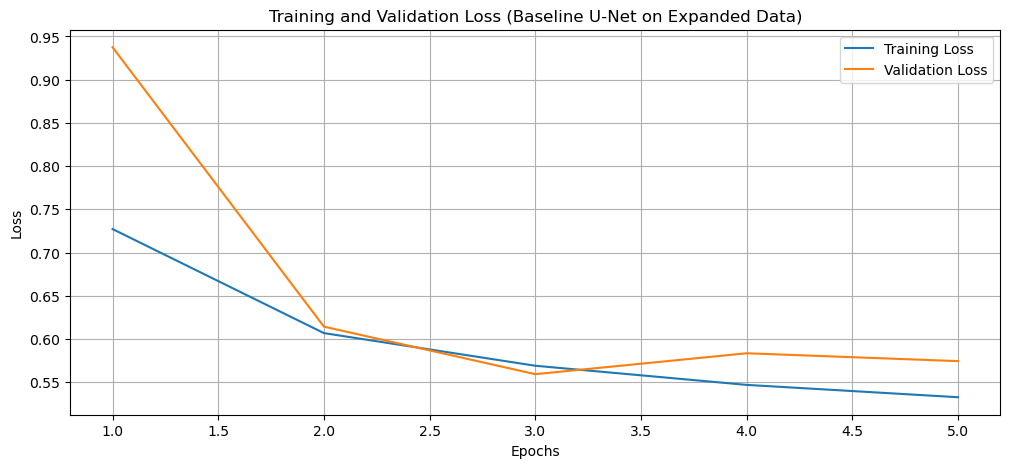

In [1]:
# --- Imports ---
import sys
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import SimpleITK as sitk

# --- CHANGE 1: Import both UNet and AttentionUNet from our models file ---
from src.data_loader import UterusDataset
from src.models import UNet, AttentionUNet # <-- ADDED UNet HERE

# --- Configuration ---
manifest_path = '../data/d2_manifest_t2fs.csv'
image_size = 256
batch_size = 16
num_epochs = 5
lr = 1e-4

# --- Data Loading and Splitting ---
full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size)
loaded_manifest = full_dataset.manifest
used_patient_indices = sorted(list(set([sm['patient_index'] for sm in full_dataset.slice_map])))
usable_patient_ids = loaded_manifest.iloc[used_patient_indices]['patient_id'].unique()
split_idx = int(len(usable_patient_ids) * 0.8)
train_ids, val_ids = usable_patient_ids[:split_idx], usable_patient_ids[split_idx:]
train_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in train_ids]
val_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]
train_dataset, val_dataset = Subset(full_dataset, train_indices), Subset(full_dataset, val_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Data successfully split:\nTraining patients: {len(train_ids)}, Validation patients: {len(val_ids)}\nTraining slices: {len(train_dataset)}\nValidation slices: {len(val_dataset)}")

# --- Metrics and Loss Function ---
def dice_score(preds, targets, epsilon=1e-6):
    preds_flat = preds.view(-1); targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5): super(DiceBCELoss, self).__init__(); self.weight = weight
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs); inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='mean')
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)
        return bce * self.weight + dice_loss * (1 - self.weight)

# --- Training and Validation Functions ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train(); running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad(); outputs = model(images); loss = criterion(outputs, masks); loss.backward(); optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images); loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs) > 0.5; dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0); running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)

# --- Main Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"\nUsing device: {device}")

# --- CHANGE 2: Instantiate the baseline UNet model ---
baseline_model_expanded = UNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(baseline_model_expanded.parameters(), lr=lr)
criterion = DiceBCELoss()

train_loss_history, val_loss_history, val_dice_history = [], [], []

print("\n--- Starting Baseline Model Training (Expanded Dataset) ---")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(baseline_model_expanded, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(baseline_model_expanded, val_loader, criterion, device)
    train_loss_history.append(train_loss); val_loss_history.append(val_loss); val_dice_history.append(val_dice)
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
print("--- Finished Training ---")

# --- Visualization ---
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss (Baseline U-Net on Expanded Data)')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

C:\Users\lytten\AppData\Local\Temp\ipykernel_20292\186886215.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


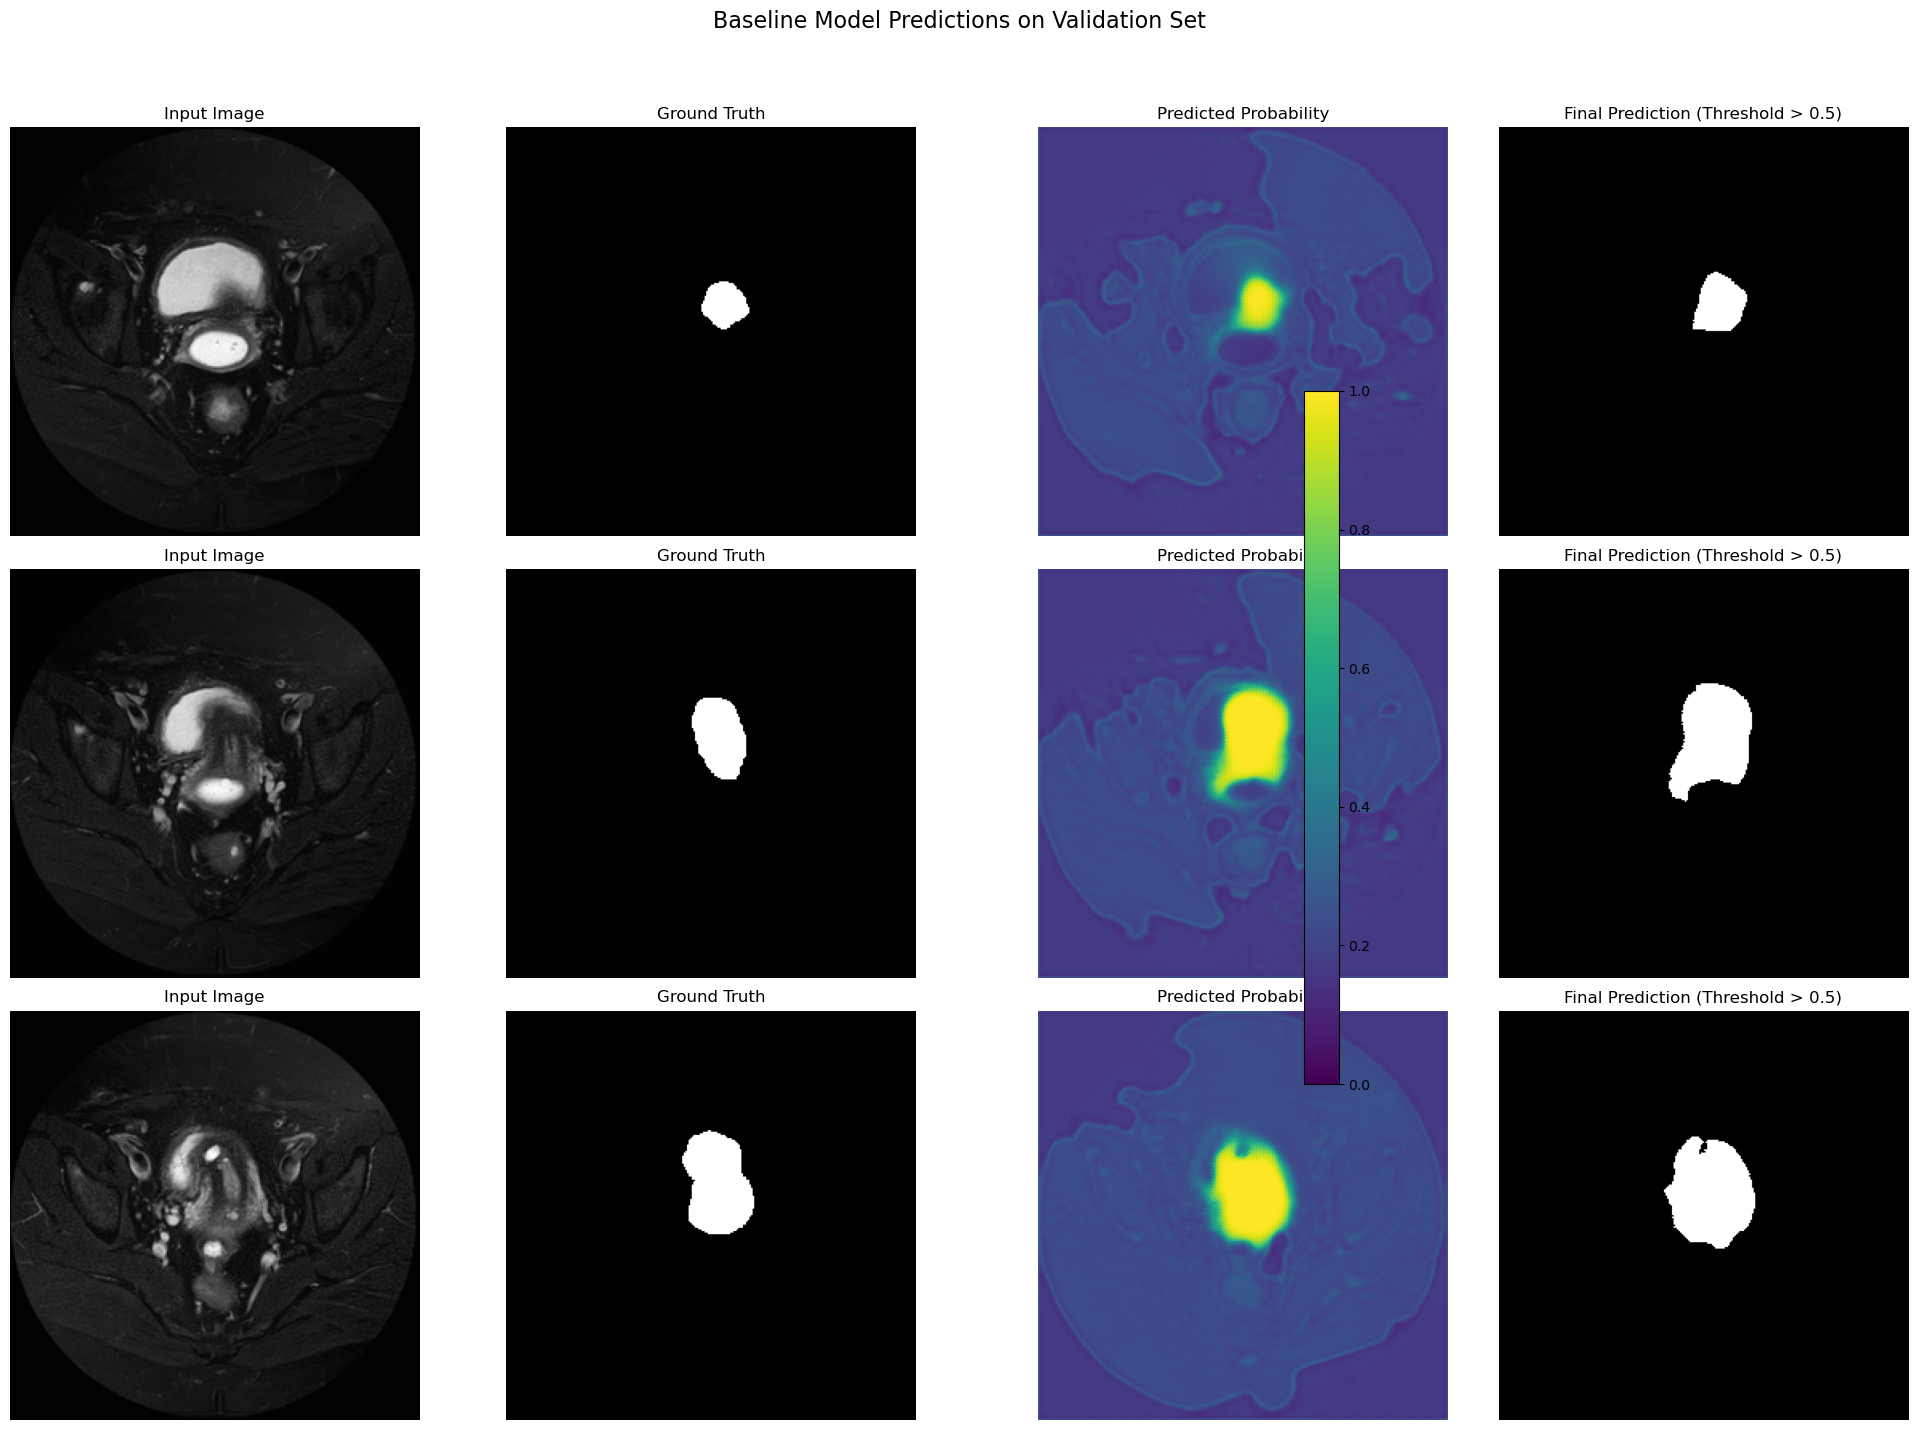

In [2]:
# --- Step 2.4 (Bonus): Visualize Model Predictions ---

# Set the model to evaluation mode
baseline_model_expanded.eval()

# Get a batch of data from the validation loader
val_images, val_masks = next(iter(val_loader))
val_images, val_masks = val_images.to(device), val_masks.to(device)

# Get the model's predictions
with torch.no_grad():
    val_outputs = baseline_model_expanded(val_images)

# Apply sigmoid to get probabilities and threshold to get binary mask
val_preds_prob = torch.sigmoid(val_outputs)
val_preds_binary = (val_preds_prob > 0.5).float()

# Move tensors to CPU for plotting
val_images_cpu = val_images.cpu()
val_masks_cpu = val_masks.cpu()
val_preds_prob_cpu = val_preds_prob.cpu()
val_preds_binary_cpu = val_preds_binary.cpu()

# Plot 3 samples side-by-side
num_samples_to_show = 3
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(20, 5 * num_samples_to_show))
plt.suptitle("Baseline Model Predictions on Validation Set", fontsize=16)

for i in range(num_samples_to_show):
    # 1. Original Image
    axes[i, 0].imshow(val_images_cpu[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')

    # 2. Ground Truth Mask
    axes[i, 1].imshow(val_masks_cpu[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')

    # 3. Predicted Probability Map
    im = axes[i, 2].imshow(val_preds_prob_cpu[i].squeeze(), cmap='viridis', vmin=0, vmax=1)
    axes[i, 2].set_title("Predicted Probability")
    axes[i, 2].axis('off')

    # 4. Final Binary Prediction
    axes[i, 3].imshow(val_preds_binary_cpu[i].squeeze(), cmap='gray')
    axes[i, 3].set_title("Final Prediction (Threshold > 0.5)")
    axes[i, 3].axis('off')

# Add a single colorbar for the probability maps
fig.colorbar(im, ax=axes[:, 2], shrink=0.6, location='right', pad=0.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [1]:
import torch
print("CUDA available? ", torch.cuda.is_available())
print("GPU name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available?  True
GPU name:  NVIDIA GeForce GTX 1070
